In this notebook we implement a random walk simulator for several types of steps and waiting times.

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from diffusioncharacterization.randomwalk_simulator.randomwalk_sim import multiple_random_walk_time
from diffusioncharacterization.randomwalk_simulator.sampler import trajectory_sampler

%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single random walk

All waiting time and step size distributions are implemented in numpy.random, so we just build a function which takes in these functions and generates a random walk accordingly.

In [60]:
def single_random_walk(number_of_steps, waiting_time_distribution, waiting_time_args, step_size_distribution, step_size_args):
    step_sizes = step_size_distribution(size=number_of_steps, **step_size_args)
    waiting_times = waiting_time_distribution(size=number_of_steps, **waiting_time_args)
    
    return waiting_times, step_sizes

In [61]:
waiting_times, step_sizes = single_random_walk(30, np.random.exponential, {'scale': 0.5}, np.random.normal, {'scale': 0.5})

In [62]:
waiting_times.shape, step_sizes.shape

((30, 1), (30, 1))

So now we need to recreate the trajectory from this:

In [71]:
trajectory = np.concatenate((np.cumsum(waiting_times)[:, None], np.cumsum(step_sizes)[:, None]), axis=1)
trajectory = np.concatenate((np.zeros((1, 2)), trajectory), axis=0)

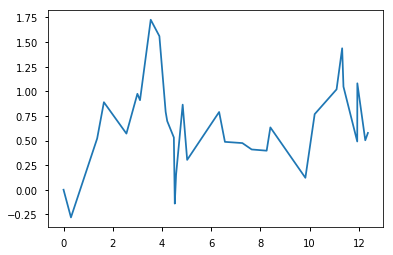

In [72]:
plt.plot(trajectory[:, 0], trajectory[:, 1])

In [75]:
def single_random_walk(number_of_steps, waiting_time_distribution, waiting_time_args, step_size_distribution, step_size_args):
    # Generating sequences of step sizes and waiting times
    step_sizes = step_size_distribution(size=number_of_steps, **step_size_args)
    waiting_times = waiting_time_distribution(size=number_of_steps, **waiting_time_args)
    
    # Creating trajectory from stepsizes and waiting times
    trajectory = np.concatenate((np.cumsum(waiting_times)[:, None], np.cumsum(step_sizes)[:, None]), axis=1)
    trajectory = np.concatenate((np.zeros((1, 2)), trajectory), axis=0)  # Adding starting position
    
    return trajectory, waiting_times, step_sizes

Text(0, 0.5, 'position')

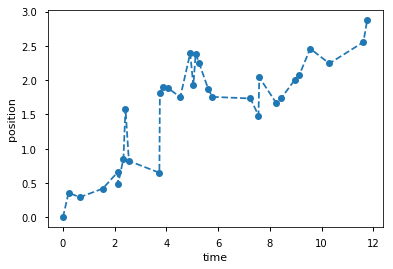

In [78]:
trajectory, waiting_times, step_sizes = single_random_walk(30, np.random.exponential, {'scale': 0.5}, np.random.normal, {'scale': 0.5})

plt.plot(trajectory[:, 0], trajectory[:, 1], 'o--')
plt.xlabel('time')
plt.ylabel('position')

Is this correct? Interpreting step size+ waiting time the length of a step.

In [124]:
position = np.concatenate([np.cumsum(step_sizes)[:, None], np.cumsum(step_sizes)[:, None]],axis=1).flatten()
time = np.concatenate([np.cumsum(waiting_times)[:, None], np.cumsum(waiting_times)[:, None]],axis=1).flatten()

time = np.concatenate([np.zeros((2,1)), time[:, None]], axis=0)
position = np.append(np.concatenate([np.zeros((1, 1)), position[:, None]], axis=0), position[-1])

In [129]:
position.shape

(62,)

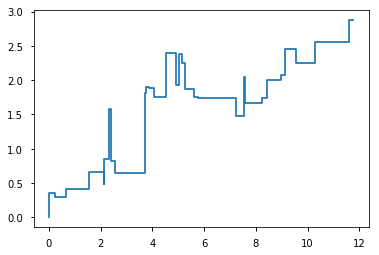

In [125]:
plt.plot(time, position)

In [132]:
def single_random_walk(number_of_steps, waiting_time_distribution, waiting_time_args, step_size_distribution, step_size_args):
    # Generating sequences of step sizes and waiting times
    step_sizes = step_size_distribution(size=number_of_steps, **step_size_args)
    waiting_times = waiting_time_distribution(size=number_of_steps, **waiting_time_args)
    
    # Creating trajectory from stepsizes and waiting times
    position = np.concatenate([np.cumsum(step_sizes)[:, None], np.cumsum(step_sizes)[:, None]],axis=1).flatten()   # times and positions need to be doubled
    time = np.concatenate([np.cumsum(waiting_times)[:, None], np.cumsum(waiting_times)[:, None]],axis=1).flatten()
    
    time = np.concatenate([np.zeros((2,1)), time[:, None]], axis=0)  # Need to add origin and end positions manually
    position = np.append(np.concatenate([np.zeros((1, 1)), position[:, None]], axis=0), position[-1])[:, None]
    
    trajectory = np.concatenate([time, position], axis=1)
    
    return trajectory, waiting_times, step_sizes

Text(0, 0.5, '|position|^2')

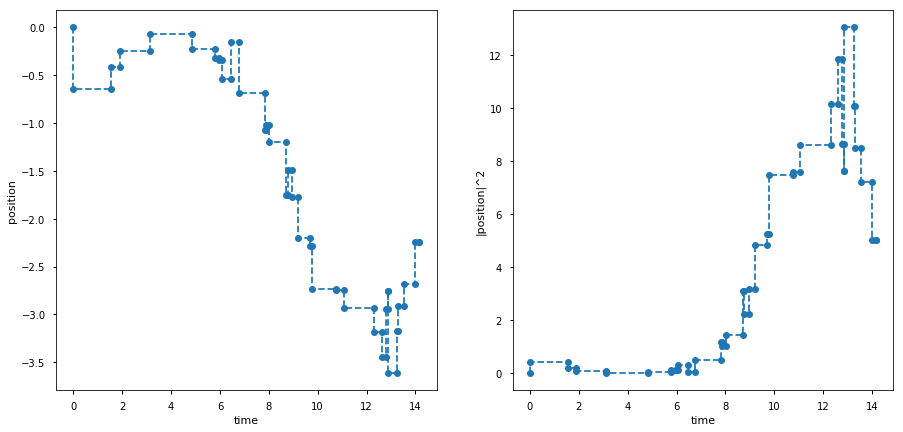

In [134]:
trajectory, waiting_times, step_sizes = single_random_walk(30, np.random.exponential, {'scale': 0.5}, np.random.normal, {'scale': 0.5})

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(trajectory[:, 0], trajectory[:, 1], 'o--')
plt.xlabel('time')
plt.ylabel('position')

plt.subplot(122)
plt.plot(trajectory[:, 0], trajectory[:, 1]**2, 'o--')
plt.xlabel('time')
plt.ylabel('|position|^2')

That works, great! Let's put it in a python function

# Multiple trajectories

So one trajectory works, let's build a function which gives back many.

In [2]:
def multiple_random_walk(num_traj, num_steps, waiting_time_dist, waiting_time_args, step_size_dist, step_size_args):
    trajectories = [single_random_walk(num_steps, waiting_time_dist, waiting_time_args, step_size_dist, step_size_args)[0] for trajectory in np.arange(num_traj)]
    trajectories = np.array(trajectories)
    return trajectories

In [167]:
trajectories = multiple_random_walk(10, 50, np.random.exponential, {'scale': 0.5}, np.random.normal, {'scale': 0.5})

Text(0, 0.5, 'position')

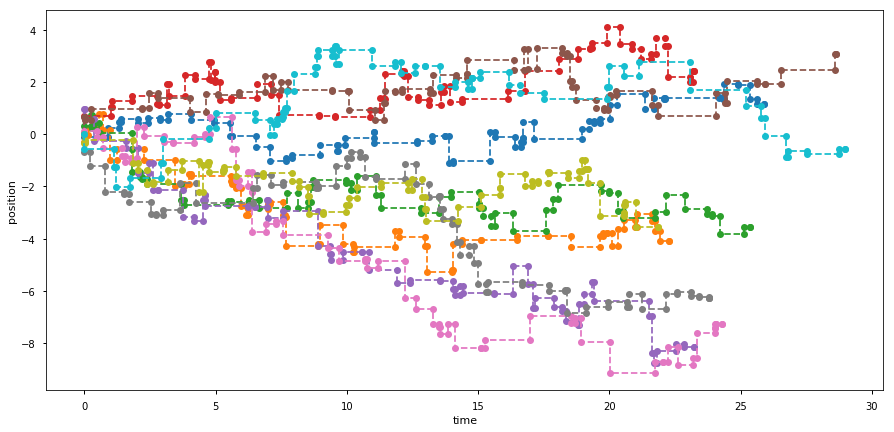

In [168]:
plt.figure(figsize=(15,7))

for traj in np.arange(trajectories.shape[0]):
    plt.plot(trajectories[traj, :, 0], trajectories[traj, :, 1], 'o--')
    
plt.xlabel('time')
plt.ylabel('position')



In [165]:
trajectories.shape

(10, 62, 2)

In [141]:
[test(x)[0] for x in np.arange(3)]

[0, 1, 2]

This all looks nice but shows a weakness; the maximum number of steps. Rather, we need a time-based method.

# Time based multiple trajectories

If we're doing time-based, its probably easier to generate all trajectories at once. However that would be a bitch to implement so we can just do one at a time.

In [209]:
def single_random_walk_time(max_time, waiting_time_dist, waiting_time_args, step_size_dist, step_size_args):
    time = [0.0]
    position = [0.0]
    
    while True:
        new_position = position[-1] + step_size_dist(size=1, **step_size_args)[0]
        new_time = time[-1] + waiting_time_dist(size=1, **waiting_time_args)[0]
        
        if new_time > max_time:
            position.extend([new_position, new_position])
            time.extend([time[-1], max_time])
            break
        else:
            position.extend([new_position, new_position])
            time.extend([time[-1], new_time])
    
    trajectory = np.array([time, position]).T
    return trajectory

In [210]:
trajectory = single_random_walk_time(10.0, np.random.exponential, {'scale': 0.5}, np.random.normal, {'scale': 0.5})

Text(0, 0.5, 'position')

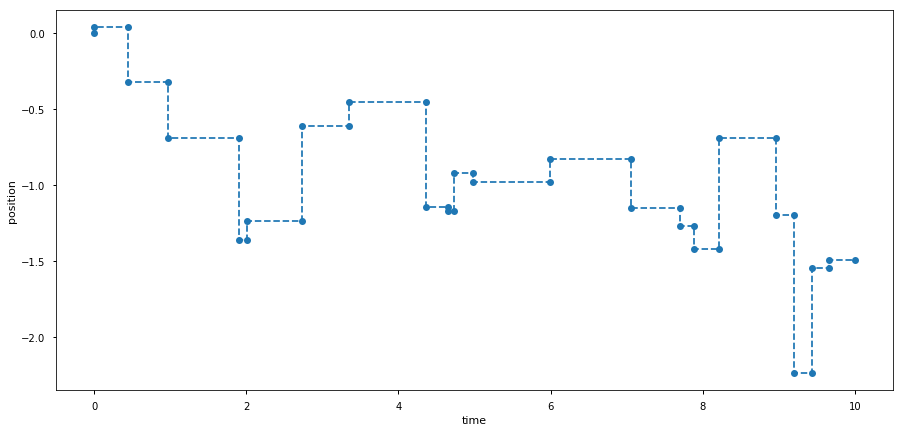

In [213]:
plt.figure(figsize=(15,7))

plt.plot(trajectory[:, 0], trajectory[:, 1], 'o--')
plt.xlabel('time')
plt.ylabel('position')

Now let's make a function to do multiple trajectories:

In [220]:
def multiple_random_walk_time(num_traj, max_time, waiting_time_dist, waiting_time_args, step_size_dist, step_size_args):
    trajectories = [single_random_walk_time(max_time, waiting_time_dist, waiting_time_args, step_size_dist, step_size_args) for trajectory in np.arange(num_traj)]
    return trajectories

In [221]:
trajectories = multiple_random_walk_time(10, 50, np.random.exponential, {'scale': 0.5}, np.random.normal, {'scale': 0.5})

Text(0, 0.5, 'position')

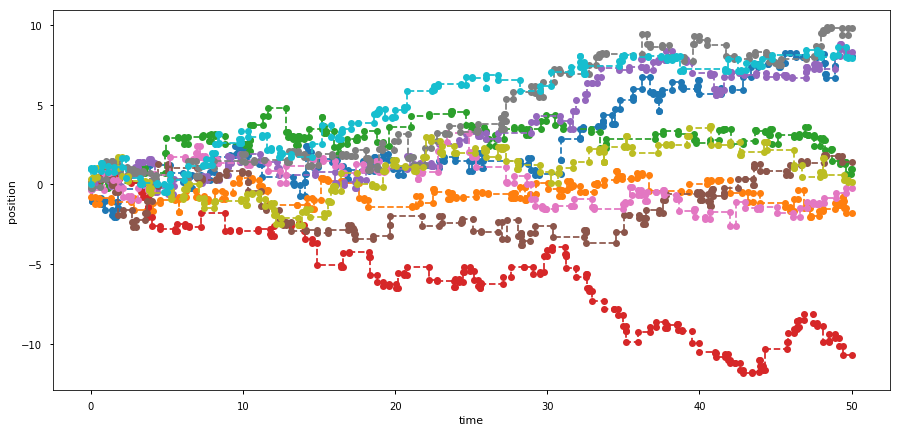

In [277]:
plt.figure(figsize=(15,7))

for traj in trajectories:
    plt.plot(traj[:, 0], traj[:, 1], 'o--')
    
plt.xlabel('time')
plt.ylabel('position')



In [219]:
trajectories[0]

array([0., 0.])

# Sampling trajectories

Since we have continuous time trajectories, we need to sample the trajectory at sampling time $t_{sample}$ for its position:L

In [224]:
test_traj = trajectories[0]

In [225]:
sample_time = 20

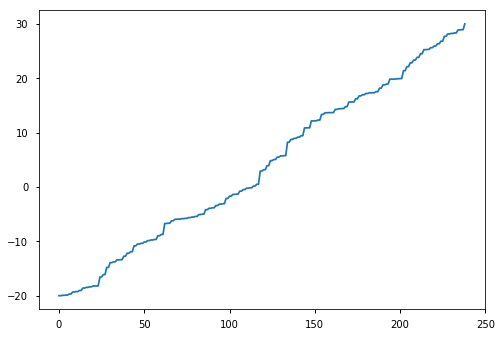

In [227]:
plt.plot(test_traj[:, 0] - sample_time)

In [262]:
sample_idx = np.argmin(np.abs(test_traj[:, 0] - sample_time)) + 1
sample_pos = test_traj[sample_idx, 1]

In [264]:
sample_pos

0.9813231557164485

In [272]:
def sampler(trajectory, sample_times):
    sample_indices = [np.argmin(np.abs(trajectory[:, 0] - time)) + 1 for time in sample_times]
    sampled_positions = np.array([trajectory[sample_idx, 1] for sample_idx in sample_indices])
    
    return sampled_positions

In [274]:
sampler(test_traj, np.arange(0, 50, 5))

array([-0.29873943,  0.69717261,  2.20164049,  1.6041175 ,  0.98132316,
        1.48113669,  0.63901198,  5.32798503,  5.675421  ,  7.40386507])

In [276]:
def trajectory_sampler(trajectories, sample_times):
    def sampler(trajectory, sample_times):
        sample_indices = [np.argmin(np.abs(trajectory[:, 0] - time)) + 1 for time in sample_times]
        sampled_positions = np.array([trajectory[sample_idx, 1] for sample_idx in sample_indices])
    
        return sampled_positions

    samples = np.array([sampler(trajectory, sample_times) for trajectory in trajectories])
    
    return samples

In [280]:
trajectory_sampler(trajectories, np.arange(0, 50, 0.1)).shape

(10, 20)

# Quick test 

In [110]:
tau = 0.1
sigma = 2.0
D = sigma**2 / tau

In [111]:
trajectories = multiple_random_walk_time(100, 1000, np.random.exponential, {'scale': tau}, np.random.normal, {'scale': sigma})

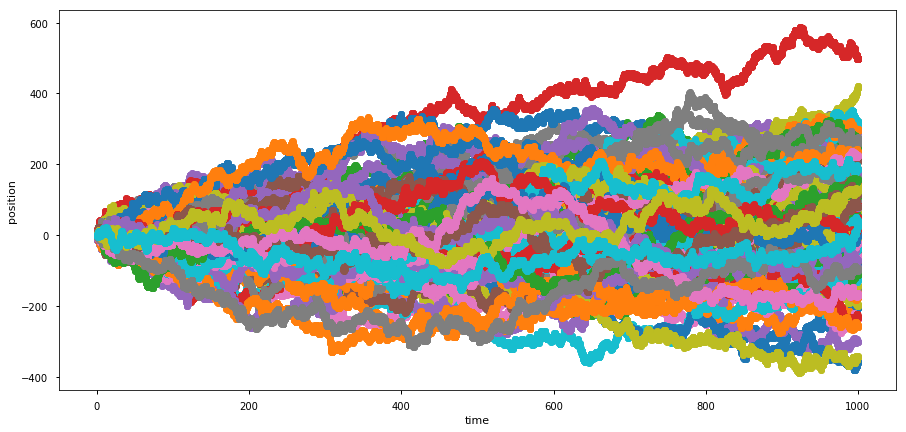

In [112]:
tplt.figure(figsize=(15,7))

for traj in trajectories:
    plt.plot(traj[:, 0], traj[:, 1], 'o--')
    
plt.xlabel('time')
plt.ylabel('position')

plt.show()

In [113]:
time = np.linspace(0, 990, 400)
positions = trajectory_sampler(trajectories, time)

In [114]:
positions.shape

(100, 400)

In [115]:
mean = np.mean(positions, axis=0)
msd = np.mean(positions**2, axis=0)

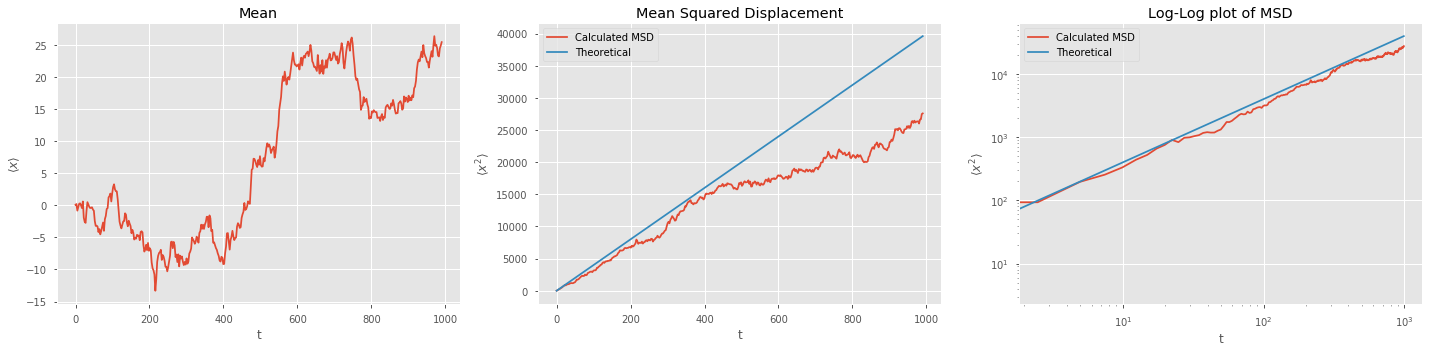

In [126]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.plot(time, mean)
plt.title('Mean')
plt.xlabel('t')
plt.ylabel(r'$\langle x \rangle$')

plt.subplot(132)
plt.plot(time, msd)
plt.plot(time, time*D)
plt.title('Mean Squared Displacement')
plt.xlabel('t')
plt.ylabel(r'$\langle x^2 \rangle$')
plt.legend(['Calculated MSD', 'Theoretical'])

plt.subplot(133)
plt.loglog(time, msd)
plt.loglog(time, time*D)
plt.title('Log-Log plot of MSD')
plt.xlabel('t')
plt.ylabel(r'$\langle x^2 \rangle$')
plt.legend(['Calculated MSD', 'Theoretical'])


plt.tight_layout()

plt.show()